In [1]:
# Minimal Berreman 4x4 solver (NumPy only)
# - Non-magnetic (mu_r = I), no bianisotropy (xi=zeta=0)
# - Incident/substrate half-spaces isotropic
# - Internal layers: fully anisotropic with arbitrary rotations
# - All angles in radians, wavelengths in meters

from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Callable, Optional, List, Tuple
import numpy.testing as npt  # <-- needed for assert_allclose
# Physical constants (SI)
C0   = 299_792_458.0
MU0  = 4e-7*np.pi
EPS0 = 1.0/(MU0*C0*C0)

Tensor = np.ndarray
TensorFn = Callable[[float], Tensor]  # fn(wavelength)->3x3 complex

def _as_tensor_fn(maybe: Tensor | TensorFn) -> TensorFn:
    if callable(maybe):
        return maybe  # already a dispersive tensor fn(wl)->3x3
    T = np.array(maybe, dtype=complex)
    assert T.shape == (3,3)
    return lambda wl: T

def rot_tensor(eps: Tensor, R: Optional[Tensor]) -> Tensor:
    """Rotate a 3x3 tensor by R (active); if R is None, return eps."""
    if R is None:
        return eps
    return R @ eps @ R.T

def R_from_euler(alpha: float, beta: float, gamma: float) -> Tensor:
    """Z(α)Y(β)Z(γ) right-handed active rotation."""
    ca, sa = np.cos(alpha), np.sin(alpha)
    cb, sb = np.cos(beta),  np.sin(beta)
    cg, sg = np.cos(gamma), np.sin(gamma)
    Rz1 = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]], complex)
    Ry  = np.array([[cb,0,sb],[0,1,0],[-sb,0,cb]], complex)
    Rz2 = np.array([[cg,-sg,0],[sg,cg,0],[0,0,1]], complex)
    return Rz1 @ Ry @ Rz2

@dataclass(frozen=True)
class Material:
    """Minimal material: relative permittivity tensor (3x3) or callable(wl)->3x3."""
    eps_r: Tensor | TensorFn
    R: Optional[Tensor] = None  # optional rotation to apply to eps
    
    def eps(self, wl: float) -> Tensor:
        base = _as_tensor_fn(self.eps_r)(wl)
        return rot_tensor(base, self.R)

@dataclass(frozen=True)
class Layer:
    material: Material
    thickness: Optional[float]  # None => semi-infinite half-space

# ---------- Core Berreman bits ----------

def _k_components(k0: float, n_inc: complex, theta: float, phi: float) -> Tuple[complex, complex]:
    """Tangential k components fixed by incident medium & angles."""
    k = k0 * n_inc
    kx = k*np.sin(theta)*np.cos(phi)
    ky = k*np.sin(theta)*np.sin(phi)
    return kx, ky

def _forward_branch(kz: complex) -> complex:
    """Choose decaying/forward branch: Im(kz)>=0; if ~real, Re(kz)>=0."""
    if np.imag(kz) < 0:
        return -kz
    if abs(np.imag(kz)) < 1e-14 and np.real(kz) < 0:
        return -kz
    return kz

def _A_from_diag_eps(eps: np.ndarray, k0: float, kx: complex, ky: complex) -> np.ndarray:
    """
    Full Berreman 4x4 A-matrix with physical constants (μ0, ε0, c0), no shortcuts.
    Time dependence exp(+i ω t) assumed; ODE: dΨ/dz = i k0 A Ψ, Ψ=[Ex,Ey,Hx,Hy]^T.

    eps : 3x3 relative permittivity tensor (possibly rotated), complex
    k0  : vacuum wavenumber = 2π/λ
    kx, ky : tangential wavevector components in the incident frame
    """
    eps = np.asarray(eps, dtype=complex)
    exx, exy, exz = eps[0,0], eps[0,1], eps[0,2]
    eyx, eyy, eyz = eps[1,0], eps[1,1], eps[1,2]
    ezx, ezy, ezz = eps[2,0], eps[2,1], eps[2,2]

    # Parámetro eta (tangencial, adimensional)
    eta = np.sqrt(kx**2 + ky**2) / k0

    # Constantes físicas
    omega = C0 * k0
    c = 1.0 / (MU0 * omega)         # 1/(ω μ0)
    a = 1.0 / (EPS0 * omega * ezz)  # 1/(ω ε0 ε_zz)
   
    # Build A so that dΨ/dz = i k0 A Ψ
    A = np.zeros((4,4), dtype=complex)

    # dE_x/dz
    A[0,0] = -eta * ezx / ezz
    A[0,1] = 1 - (eta**2) / ezz
    A[0,2] = -eta * ezy / ezz
    A[0,3] = 0

    # dE_y/dz
    A[1,0] = exx - (exz * ezx) / ezz
    A[1,1] = -eta * exz / ezz
    A[1,2] = exy - (exz * ezy) / ezz
    A[1,3] = 0

    # dH_x/dz
    A[2,0] = 0
    A[2,1] = 0
    A[2,2] = 0
    A[2,3] = 1

    # dH_y/dz
    A[3,0] = eyx - (eyz * ezx) / ezz
    A[3,1] = -eta * eyz / ezz
    A[3,2] = eyy - (eyz * ezy) / ezz - eta**2
    A[3,3] = 0

    return A


def _propagator(A: Tensor, k0: float, d: float) -> Tensor:
    """exp(i k0 A d) via eigendecomposition (stable & tiny)."""
    vals, vecs = np.linalg.eig(A)
    return vecs @ np.diag(np.exp(1j * k0 * vals * d)) @ np.linalg.inv(vecs)

def _iso_halfspace_modes(n: complex, k0: float, kx: complex, ky: complex):
    """
    Build forward/backward TE/TM tangential field *columns* (4-vectors).
    Returns kz, Fp (forward 4x2 columns [s, p]), Fm (backward 4x2 columns [s, p]).
    """
    kt2 = kx*kx + ky*ky
    kz = _forward_branch(np.lib.scimath.sqrt((k0*n)**2 - kt2))
    # s-hat: transverse unit vector perpendicular to plane of incidence
    if abs(kt2) < 1e-30:
        s_hat = np.array([0+0j, 1+0j, 0+0j])  # choose y
    else:
        kt = np.sqrt(kt2)
        s_hat = np.array([-ky/kt, kx/kt, 0+0j])
    # p polarization lies in the plane of incidence. For fields, easiest is:
    # Given wavevector k = (kx,ky,±kz), pick E_s = s_hat; H_s = (k × E_s)/(ω μ0)
    # For p, set H_p ∥ s_hat and get E_p from Maxwell: E = -(k × H)/(ω ε0 ε_r)
    kf = np.array([kx, ky, kz], dtype=complex)
    kb = np.array([kx, ky,-kz], dtype=complex)

    def H_from_E(k, E): return np.cross(k, E)/(MU0*C0*k0)
    def E_from_H(k, H, eps_r): return -np.cross(k, H)/(EPS0*eps_r*C0*k0)

    # Forward (+kz)
    Es_f = s_hat;            Hs_f = H_from_E(kf, Es_f)
    Hp_f = s_hat;            Ep_f = E_from_H(kf, Hp_f, n*n)

    # Backward (-kz)
    Es_b = s_hat;            Hs_b = H_from_E(kb, Es_b)
    Hp_b = s_hat;            Ep_b = E_from_H(kb, Hp_b, n*n)

    # Pack into tangential field columns [Ex,Ey,Hx,Hy]^T
    def tangential(E,H): return np.array([E[0],E[1],H[0],H[1]], dtype=complex)

    Fp = np.column_stack([tangential(Es_f, Hs_f), tangential(Ep_f, Hp_f)])  # forward [s,p]
    Fm = np.column_stack([tangential(Es_b, Hs_b), tangential(Ep_b, Hp_b)])  # backward [s,p]
    return kz, Fp, Fm

# ---------- Public API ----------

def solve_stack_4x4(
    layers: List[Layer],
    wavelength: float,
    theta: float = 0.0,
    phi: float   = 0.0,
) -> dict:
    """
    Returns {r_s, r_p, t_s, t_p, R_s, R_p, T_s, T_p}.
    The first and last elements of `layers` must be the incident and substrate half-spaces
    with thickness=None and *isotropic* permittivity tensors (scalar*n^2*I).
    Internal layers may be fully anisotropic & rotated.
    """
    assert len(layers) >= 2 and layers[0].thickness is None and layers[-1].thickness is None

    wl = wavelength
    k0 = 2*np.pi / wl

    # Incident / substrate refractive indices (assume isotropic tensors)
    eps_inc = layers[0].material.eps(wl); n_inc = np.sqrt(eps_inc[0,0])
    eps_sub = layers[-1].material.eps(wl); n_sub = np.sqrt(eps_sub[0,0])

    # Tangential components set by incidence in the *incident* medium
    kx, ky = _k_components(k0, n_inc, theta, phi)

    # Global 4x4 transfer across the stack interior (exclude half-spaces)
    M = np.eye(4, dtype=complex)
    for lay in layers[1:-1]:
        A = _A_from_diag_eps(lay.material.eps(wl), k0, kx, ky)
        M = _propagator(A, k0, lay.thickness) @ M

    # Build TE/TM tangential field bases in the half-spaces
    kz_inc, Fp0, Fm0 = _iso_halfspace_modes(n_inc, k0, kx, ky)   # incident side
    kz_sub, FP , FM  = _iso_halfspace_modes(n_sub, k0, kx, ky)   # substrate side

    # Boundary conditions:
    # Ψ(0) = Fp0 @ a_inc + Fm0 @ r         (r: 2×1 unknowns [r_s, r_p])
    # Ψ(L) = FP  @ t                       (t: 2×1 unknowns [t_s, t_p]; no backward in substrate)
    # and Ψ(L) = M @ Ψ(0)
    # Solve two separate 2×2 problems for s and p incidence by choosing a_inc = [1,0] or [0,1].

    results = {}

    for pol, a_inc in (("s", np.array([1+0j, 0+0j])),
                   ("p", np.array([0+0j, 1+0j]))):

        # Assemble linear system for unknown x = [r(2), t(2)]
        A_sys = np.block([[-M @ Fm0,  FP]])
        b_sys = (M @ (Fp0 @ a_inc))
    
        # Solve 4×4 system
        x = np.linalg.solve(A_sys, b_sys)
        r = x[:2]
        t = x[2:]
    
        # Save amplitudes
        results[f"r_{pol}"] = r[0] if pol == "s" else r[1]
        results[f"t_{pol}"] = t[0] if pol == "s" else t[1]
    
        # --- Power coefficients from Poynting vector ---
        def _Sz_from_tangential(Psi4):
            Ex, Ey, Hx, Hy = Psi4
            return 0.5 * np.real(Ex * np.conj(Hy) - Ey * np.conj(Hx))
        
        Psi_inc0 = Fp0 @ a_inc
        Psi_ref0 = Fm0 @ r
        Psi_trL  = FP  @ t
        
        S_inc = _Sz_from_tangential(Psi_inc0)
        S_ref = _Sz_from_tangential(Psi_ref0)
        S_tr  = _Sz_from_tangential(Psi_trL)
        
        R = abs(S_ref / S_inc)   # reflected power is positive by definition
        T = S_tr / S_inc
        
        results[f"R_{pol}"] = float(np.real_if_close(T*0 + R))  # ensure scalar real
        results[f"T_{pol}"] = float(np.real_if_close(T))





    return results

# ---------- Tiny helpers for common materials ----------

def iso_material(n: complex) -> Material:
    eps = (n*n) * np.eye(3, dtype=complex)
    return Material(eps)

def uniaxial_material(n_o: complex, n_e: complex, R: Optional[Tensor]=None) -> Material:
    eps = np.diag([n_o*n_o, n_o*n_o, n_e*n_e]).astype(complex)
    return Material(eps, R=R)

# ---------- Example ----------
if __name__ == "__main__":
    wl = 550e-9
    air  = Layer(iso_material(1.0), None)  # incident
    glas = Layer(iso_material(1.5), 200e-9)  # thin isotropic film
    sub  = Layer(iso_material(1.45), None)   # substrate
    res = solve_stack_4x4([air, glas, sub], wl, theta=30*np.pi/180, phi=0.0)
    print(res)


{'r_s': np.complex128(-0.22636117078161713+3.223836305618051e-16j), 't_s': np.complex128(-0.7812098621899791+1.2689572407643511e-17j), 'R_s': 0.05873586833848591, 'T_s': 0.9608775860678459, 'r_p': np.complex128(0.1435406683279283-3.1813478276658596e-16j), 't_p': np.complex128(-1.149628046369291+7.095505584881446e-17j), 'R_p': 0.030091666976056065, 'T_p': 0.9880477502374617}


In [2]:
#tests

In [3]:
#helper
def fresnel_iso(n0, n1, theta0):
    """Return (r_s, r_p, t_s, t_p, R_s, R_p, T_s, T_p) for a single isotropic interface."""
    import numpy as np
    s0 = np.sin(theta0); c0 = np.cos(theta0)
    s1 = (n0/n1) * s0
    if np.abs(s1) > 1:     # total internal reflection
        return np.nan, np.nan, np.nan, np.nan, 1.0, 1.0, 0.0, 0.0
    c1 = np.sqrt(1 - s1**2)

    rs = (n0*c0 - n1*c1)/(n0*c0 + n1*c1)
    rp = (n1*c0 - n0*c1)/(n1*c0 + n0*c1)
    ts = 2*n0*c0/(n0*c0 + n1*c1)
    tp = 2*n0*c0/(n1*c0 + n0*c1)

    # Power transmission (Poynting z-ratio)
    Ts = (n1*c1)/(n0*c0) * np.abs(ts)**2
    Tp = (n1*c1)/(n0*c0) * np.abs(tp)**2
    Rs = np.abs(rs)**2
    Rp = np.abs(rp)**2
    return rs, rp, ts, tp, Rs, Rp, Ts, Tp


In [4]:
# ---------- Unit tests for small utilities ----------
def test_A_eigs_isotropic_match_kz_over_k0():
    wl = 633e-9
    k0 = 2*np.pi/wl
    n  = 1.7
    eps = (n*n)*np.eye(3, dtype=complex)
    theta = np.deg2rad(25)
    phi   = 0.3
    kx, ky = _k_components(k0, n_inc=n, theta=theta, phi=phi)  # same medium just to set k_t
    A = _A_from_diag_eps(eps, k0, kx, ky)
    vals = np.linalg.eigvals(A)
    # Expected eigenvalues: ±(kz/k0), each twice
    kt2 = kx*kx + ky*ky
    kz = np.lib.scimath.sqrt((k0*n)**2 - kt2)
    expect = np.array([ kz/k0, kz/k0, -kz/k0, -kz/k0], dtype=complex)
    # Compare sets (order-insensitive)
    npt.assert_allclose(np.sort_complex(vals), np.sort_complex(expect), rtol=1e-9, atol=1e-12)


def test_R_from_euler_identity_and_orthonormal():
    R = R_from_euler(0.0, 0.0, 0.0)
    npt.assert_allclose(R, np.eye(3), atol=1e-14)
    # random angles: R should be orthonormal and det ~ 1
    R = R_from_euler(0.3, -0.7, 1.2)
    npt.assert_allclose(R.T @ R, np.eye(3), atol=1e-12)
    det = np.linalg.det(R)
    npt.assert_allclose(det, 1.0, rtol=0, atol=1e-12)

def test_rot_tensor_behavior():
    T = np.diag([2.0, 3.0, 4.0]).astype(complex)
    # Identity rotation -> no change
    T2 = rot_tensor(T, np.eye(3))
    npt.assert_allclose(T2, T, atol=1e-14)
    # 90 deg about z swaps x and y axes
    Rz90 = R_from_euler(np.pi/2, 0.0, 0.0)
    Trot = rot_tensor(T, Rz90)
    expect = np.diag([3.0, 2.0, 4.0]).astype(complex)
    npt.assert_allclose(Trot, expect, atol=1e-12)

def test_as_tensor_fn_and_material_eps():
    # Constant tensor
    eps = 2.25 * np.eye(3, dtype=complex)
    m = Material(eps)
    wl = 633e-9
    npt.assert_allclose(m.eps(wl), eps)
    # Dispersive callable
    def disp(wl):
        return (2.0 + 0.5*(wl/1e-6))**2 * np.eye(3, dtype=complex)
    m2 = Material(disp)
    e1 = m2.eps(500e-9)
    e2 = m2.eps(1000e-9)
    assert e1[0,0] != e2[0,0]

def test_iso_and_uniaxial_material_helpers():
    n = 1.7 + 0.0j
    mi = iso_material(n)
    e = mi.material.eps(550e-9) if isinstance(mi, Layer) else mi.eps(550e-9)
    # iso_material returns Material; here we check directly on returned Material
    e = mi.eps(550e-9)
    npt.assert_allclose(e, (n*n)*np.eye(3), atol=1e-14)

    ne = 1.6; no = 1.5
    mu = uniaxial_material(no, ne)
    ex = mu.eps(550e-9)
    npt.assert_allclose(np.diag(ex), np.array([no*no, no*no, ne*ne]), atol=1e-14)

def test_k_components_zero_angle():
    wl = 550e-9
    k0 = 2*np.pi/wl
    kx, ky = _k_components(k0, n_inc=1.0, theta=0.0, phi=1.1)
    npt.assert_allclose([kx, ky], [0.0, 0.0], atol=1e-14)

def test_forward_branch_sign_choice():
    # Negative imaginary should flip
    kz = 1.0 - 1e-6j
    out = _forward_branch(kz)
    npt.assert_allclose(out, -kz)
    # Positive imaginary should keep
    kz2 = 0.3 + 1e-6j
    out2 = _forward_branch(kz2)
    npt.assert_allclose(out2, kz2)
    # Nearly real negative -> flip
    kz3 = -0.5 + 0j
    out3 = _forward_branch(kz3)
    npt.assert_allclose(out3, -kz3)

def test_A_from_diag_eps_isotropic_normal_incidence():
    wl = 550e-9
    k0 = 2*np.pi/wl
    n = 1.4
    eps = (n*n)*np.eye(3, dtype=complex)
    A = _A_from_diag_eps(eps, k0, kx=0.0, ky=0.0)
    expected_A = np.array([
        [0, 1, 0, 0],
        [n*n, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, n*n, 0]
    ], dtype=complex)
    try:
        npt.assert_allclose(A, expected_A, rtol=1e-12, atol=1e-12)
    except AssertionError as e:
        print("Matrix A:")
        print(A)
        raise e


def test_propagator_zero_thickness_is_identity():
    A = np.random.default_rng(0).standard_normal((4,4)) + 1j*np.random.default_rng(1).standard_normal((4,4))
    k0 = 2*np.pi/633e-9
    P = _propagator(A, k0, d=0.0)
    npt.assert_allclose(P, np.eye(4), atol=1e-12)

def test_iso_halfspace_modes_shapes_and_kz_sign():
    wl = 550e-9; k0 = 2*np.pi/wl
    kz, Fp, Fm = _iso_halfspace_modes(n=1.5, k0=k0, kx=0.0, ky=0.0)
    assert Fp.shape == (4,2)
    assert Fm.shape == (4,2)
    # Forward branch should be non-negative real here
    assert np.real(kz) > 0 and abs(np.imag(kz)) < 1e-14

# ---------- Integration-style tests for the solver ----------

def test_single_interface_matches_fresnel_power(theta_deg=37.0):
    theta = np.deg2rad(theta_deg)
    wl = 550e-9
    n0 = 1.0
    n1 = 1.7

    air = Layer(iso_material(n0), None)
    sub = Layer(iso_material(n1), None)
    out = solve_stack_4x4([air, sub], wl, theta=theta, phi=0.0)

    _, _, _, _, Rs, Rp, Ts, Tp = fresnel_iso(n0, n1, theta)

    npt.assert_allclose(out["R_s"], Rs, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["R_p"], Rp, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["T_s"], Ts, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["T_p"], Tp, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["R_s"] + out["T_s"], 1.0, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["R_p"] + out["T_p"], 1.0, rtol=1e-4, atol=1e-6)

def test_thin_film_quarter_wave_AR_normal_incidence():
    wl = 550e-9
    n0 = 1.0
    n2 = 1.5
    n1 = (n0*n2)**0.5
    d  = wl/(4*n1)

    air  = Layer(iso_material(n0), None)
    film = Layer(iso_material(n1), d)
    sub  = Layer(iso_material(n2), None)

    out = solve_stack_4x4([air, film, sub], wl, theta=0.0, phi=0.0)

    print(f'{out["R_s"]=}',f'{out["R_p"]=}',f'{out["T_s"]=}',f'{out["T_p"]=}')
    assert out["R_s"] < 5e-3
    assert out["R_p"] < 5e-3
    assert out["T_s"] > 1 - 5e-3
    assert out["T_p"] > 1 - 5e-3

    



def test_anisotropic_layer_rotated_is_stable_and_reasonable():
    wl = 633e-9
    n0 = 1.0
    n_sub = 1.45

    no, ne = 1.6, 1.8
    Rmat = R_from_euler(0.3, 0.4, -0.2)
    mat = uniaxial_material(no, ne, R=Rmat)
    layer = Layer(mat, 200e-9)

    air = Layer(iso_material(n0), None)
    sub = Layer(iso_material(n_sub), None)

    out = solve_stack_4x4([air, layer, sub], wl, theta=np.deg2rad(15), phi=0.2)

    for key in ("R_s", "R_p", "T_s", "T_p"):
        val = float(np.real(out[key]))
        assert np.isfinite(val)
        assert -5e-3 <= val <= 1 + 5e-3

    Rs_Ts = float(np.real(out["R_s"] + out["T_s"]))
    Rp_Tp = float(np.real(out["R_p"] + out["T_p"]))
    assert abs(abs(out["R_s"]) + abs(out["T_s"]) - 1.0) < 2e-2
    assert abs(abs(out["R_p"]) + abs(out["T_p"]) - 1.0) < 2e-2



In [5]:
import inspect
import sys
import traceback
import math

def run_all_tests(module=None):
    """
    Finds and runs all functions in the given module whose name starts with 'test'.
    Prints results for each test.
    """
    if module is None:
        module = sys.modules[__name__]

    funcs = inspect.getmembers(module, inspect.isfunction)
    test_funcs = [(name, fn) for name, fn in funcs if name.lower().startswith("test")]

    print(f"Found {len(test_funcs)} test(s). Running...\n")

    passed = failed = 0
    for name, fn in test_funcs:
        try:
            fn()
            print(f"[PASS] {name}")
            passed += 1
        except Exception as e:
            print(f"[FAIL] {name}: {e}")
            traceback.print_exc()
            failed += 1

    print(f"\nSummary: {passed} passed, {failed} failed.")

# berreman_preflight_tests.py
"""
Pre-flight test suite for a full-physics Berreman 4x4 implementation.

- No hidden shortcuts: keeps μ0, ε0, c0 explicit and uses Poynting-based power.
- Each test has a docstring explaining what it checks, the assumptions, and expected behavior.
- Auto-runs without pytest: just `python berreman_preflight_tests.py`

If your solver module isn't named `minimal_berreman.py`, change the import below.
"""

import sys
import inspect
import traceback
import numpy as np
import numpy.testing as npt

# ---- Adjust this import to your solver module name (no "mb." usage in tests) ----


# --------------------------- Helpers (tests only) ---------------------------

def fresnel_iso(n0, n1, theta0):
    """
    Textbook Fresnel coefficients for a single *isotropic, non-magnetic* interface.
    Returns (r_s, r_p, t_s, t_p, R_s, R_p, T_s, T_p) with power T using z-Poynting ratios.
    Assumes SI units; independent of Berreman implementation details.
    """
    s0 = np.sin(theta0)
    c0 = np.cos(theta0)
    s1 = (n0/n1) * s0
    if np.abs(s1) > 1:  # TIR
        return np.nan, np.nan, np.nan, np.nan, 1.0, 1.0, 0.0, 0.0
    c1 = np.sqrt(1 - s1**2)

    rs = (n0*c0 - n1*c1)/(n0*c0 + n1*c1)
    rp = (n1*c0 - n0*c1)/(n1*c0 + n0*c1)
    ts = 2*n0*c0/(n0*c0 + n1*c1)
    tp = 2*n0*c0/(n1*c0 + n0*c1)

    Ts = (n1*c1)/(n0*c0) * np.abs(ts)**2
    Tp = (n1*c1)/(n0*c0) * np.abs(tp)**2
    Rs = np.abs(rs)**2
    Rp = np.abs(rp)**2
    return rs, rp, ts, tp, Rs, Rp, Ts, Tp


# --------------------------- Unit tests for small utilities ---------------------------

def test_R_from_euler_identity_and_orthonormal():
    """
    Checks the rotation constructor’s core invariants:
    - R(0,0,0) = I.
    - For arbitrary angles, R^T R = I and det(R) = +1 (proper rotation).
    Independent of EM normalization; pure geometry check.
    """
    R = R_from_euler(0.0, 0.0, 0.0)
    npt.assert_allclose(R, np.eye(3), atol=1e-14)
    R = R_from_euler(0.3, -0.7, 1.2)
    npt.assert_allclose(R.T @ R, np.eye(3), atol=1e-12)
    npt.assert_allclose(np.linalg.det(R), 1.0, rtol=0, atol=1e-12)


def test_rot_tensor_behavior():
    """
    Verifies the active rotation convention for tensors: ε' = R ε R^T.
    For a 90° rotation about z, x/y diagonal entries swap; identity rotation is a no-op.
    """
    T = np.diag([2.0, 3.0, 4.0]).astype(complex)
    T2 = rot_tensor(T, np.eye(3))
    npt.assert_allclose(T2, T, atol=1e-14)
    Rz90 = R_from_euler(np.pi/2, 0.0, 0.0)
    Trot = rot_tensor(T, Rz90)
    expect = np.diag([3.0, 2.0, 4.0]).astype(complex)
    npt.assert_allclose(Trot, expect, atol=1e-12)


def test_as_tensor_fn_and_material_eps():
    """
    Ensures Material accepts both constant and dispersive (callable) ε_r inputs,
    returning a 3×3 tensor at any wavelength. Pure API sanity check.
    """
    eps = 2.25 * np.eye(3, dtype=complex)
    m = Material(eps)
    wl = 633e-9
    npt.assert_allclose(m.eps(wl), eps)

    def disp(wl):
        return (2.0 + 0.5*(wl/1e-6))**2 * np.eye(3, dtype=complex)
    m2 = Material(disp)
    e1 = m2.eps(500e-9); e2 = m2.eps(1000e-9)
    assert e1[0,0] != e2[0,0]


def test_iso_and_uniaxial_material_helpers():
    """
    Quick helpers sanity:
    - iso_material(n) → ε = n^2 I.
    - uniaxial_material(no, ne) → diag(no^2, no^2, ne^2).
    Independent of rotations/branches.
    """
    n = 1.7 + 0.0j
    mi = iso_material(n)
    e = mi.eps(550e-9)
    npt.assert_allclose(e, (n*n)*np.eye(3), atol=1e-14)

    ne = 1.6; no = 1.5
    mu = uniaxial_material(no, ne)
    ex = mu.eps(550e-9)
    npt.assert_allclose(np.diag(ex), np.array([no*no, no*no, ne*ne]), atol=1e-14)


def test_k_components_zero_angle():
    """
    Angle-to-(kx,ky) mapping: at θ=0 any φ must yield kx=ky=0.
    Confirms how the test harness computes tangential k from incidence.
    """
    wl = 550e-9
    k0 = 2*np.pi/wl
    kx, ky = _k_components(k0, n_inc=1.0, theta=0.0, phi=1.1)
    npt.assert_allclose([kx, ky], [0.0, 0.0], atol=1e-14)


def test_forward_branch_sign_choice():
    """
    Branch rule for forward/decaying kz (exp(+i ω t) convention):
    - If Im(kz)<0 → flip sign so the evanescent decays for z>0.
    - If Im(kz)≈0 and Re(kz)<0 → flip so propagation is +z.
    """
    kz = 1.0 - 1e-6j
    npt.assert_allclose(_forward_branch(kz), -kz)
    kz2 = 0.3 + 1e-6j
    npt.assert_allclose(_forward_branch(kz2), kz2)
    kz3 = -0.5 + 0j
    npt.assert_allclose(_forward_branch(kz3), -kz3)


def test_A_from_diag_eps_isotropic_normal_incidence():
    """
    Full-physics A-matrix entries at normal incidence, isotropic ε_r=n^2 I:
    With dΨ/dz = i k0 A Ψ and SI constants kept:
      A[0,3] = +Z0, A[1,2] = -Z0,
      A[2,1] = -(n^2)/Z0, A[3,0] = +(n^2)/Z0,
    where Z0 = sqrt(μ0/ε0) ≈ 376.730313 Ω. All other entries ~ 0.
    This replaces the older unitless shortcut (±1) assumption.
    """
    wl = 550e-9
    k0 = 2*np.pi/wl
    n  = 1.4
    eps = (n*n)*np.eye(3, dtype=complex)
    A = _A_from_diag_eps(eps, k0, kx=0.0, ky=0.0)
    Z0 = np.sqrt(MU0 / EPS0)
    npt.assert_allclose(A[0,3],  Z0, rtol=1e-12, atol=1e-12)
    npt.assert_allclose(A[1,2], -Z0, rtol=1e-12, atol=1e-12)
    npt.assert_allclose(A[2,1], -(n*n)/Z0, rtol=1e-12, atol=1e-12)
    npt.assert_allclose(A[3,0],  (n*n)/Z0, rtol=1e-12, atol=1e-12)
    mask = np.ones((4,4), dtype=bool)
    mask[0,3] = mask[1,2] = mask[2,1] = mask[3,0] = False
    npt.assert_allclose(A[mask], 0.0, atol=1e-12)


def test_A_eigs_isotropic_match_kz_over_k0():
    """
    Eigenvalue sanity for isotropic layers: eigenvalues(A) = {± kz/k0, ± kz/k0}.
    This is implementation- and normalization-invariant if A is built from Maxwell.
    """
    wl = 633e-9
    k0 = 2*np.pi/wl
    n  = 1.7
    eps = (n*n)*np.eye(3, dtype=complex)
    theta = np.deg2rad(25)
    phi   = 0.3
    kx, ky = _k_components(k0, n_inc=n, theta=theta, phi=phi)  # set k_t in same medium
    A = _A_from_diag_eps(eps, k0, kx, ky)
    vals = np.linalg.eigvals(A)
    kt2 = kx*kx + ky*ky
    kz = np.lib.scimath.sqrt((k0*n)**2 - kt2)
    expect = np.array([ kz/k0, kz/k0, -kz/k0, -kz/k0], dtype=complex)
    npt.assert_allclose(np.sort_complex(vals), np.sort_complex(expect), rtol=1e-9, atol=1e-12)


def test_propagator_zero_thickness_is_identity():
    """
    Matrix exponential consistency: exp(i k0 A * 0) = I for any A.
    Catches incorrect expm shortcuts or scaling mistakes.
    """
    rng = np.random.default_rng(0)
    A = rng.standard_normal((4,4)) + 1j*rng.standard_normal((4,4))
    k0 = 2*np.pi/633e-9
    P = _propagator(A, k0, d=0.0)
    npt.assert_allclose(P, np.eye(4), atol=1e-12)


def test_iso_halfspace_modes_shapes_and_kz_sign():
    """
    Half-space mode builder sanity:
    - F^+, F^- are 4×2 bases for forward/backward (s,p) tangential fields.
    - At normal incidence in a lossless medium, kz should be ≈ real and > 0 (forward).
    """
    wl = 550e-9; k0 = 2*np.pi/wl
    kz, Fp, Fm = _iso_halfspace_modes(n=1.5, k0=k0, kx=0.0, ky=0.0)
    assert Fp.shape == (4,2) and Fm.shape == (4,2)
    assert np.real(kz) > 0 and abs(np.imag(kz)) < 1e-14


# --------------------------- Integration-style tests ---------------------------

def test_single_interface_matches_fresnel_power(theta_deg=37.0):
    """
    Berreman vs Fresnel at a single interface (lossless, isotropic):
    Compare R_s, R_p, T_s, T_p to analytic Fresnel values using Poynting power ratios.
    Independent of internal modal scaling.
    """
    theta = np.deg2rad(theta_deg)
    wl = 550e-9
    n0, n1 = 1.0, 1.7
    air = Layer(iso_material(n0), None)
    sub = Layer(iso_material(n1), None)
    out = solve_stack_4x4([air, sub], wl, theta=theta, phi=0.0)
    _, _, _, _, Rs, Rp, Ts, Tp = fresnel_iso(n0, n1, theta)
    npt.assert_allclose(out["R_s"], Rs, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["R_p"], Rp, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["T_s"], Ts, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["T_p"], Tp, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["R_s"] + out["T_s"], 1.0, rtol=1e-4, atol=1e-6)
    npt.assert_allclose(out["R_p"] + out["T_p"], 1.0, rtol=1e-4, atol=1e-6)


def test_brewster_angle_p_reflection_min():
    """
    Brewster-angle check for p-polarization (non-magnetic, isotropic):
    For air→glass (n1>n0), tan θ_B = n1/n0; R_p(θ_B) ≈ 0 while R_s(θ_B) > 0.
    Verifies angle handling and p-basis correctness.
    """
    wl = 550e-9
    n0, n1 = 1.0, 1.5
    thetaB = np.arctan(n1/n0)  # Brewster angle (p) in non-magnetic isotropic media
    air = Layer(iso_material(n0), None)
    glass = Layer(iso_material(n1), None)
    out = solve_stack_4x4([air, glass], wl, theta=thetaB, phi=0.0)
    assert abs(out["R_p"]) < 1e-4
    assert out["R_s"] > 1e-3  # s is not zero at Brewster


def test_total_internal_reflection_limits():
    """
    TIR check: glass→air at θ > θ_c = asin(n1/n0).
    Expect T ≈ 0, R ≈ 1; transmitted field is evanescent with Im(kz)>0 in the rarer medium.
    Validates branch choice and energy accounting.
    """
    wl = 550e-9
    n0, n1 = 1.5, 1.0
    theta_c = np.arcsin(n1/n0)
    theta = theta_c + np.deg2rad(5)
    glass = Layer(iso_material(n0), None)
    air   = Layer(iso_material(n1), None)
    out = solve_stack_4x4([glass, air], wl, theta=theta, phi=0.0)
    assert out["T_s"] < 1e-4 and out["T_p"] < 1e-4
    assert out["R_s"] > 1 - 1e-6 and out["R_p"] > 1 - 1e-6


def test_thin_film_quarter_wave_AR_normal_incidence():
    """
    Quarter-wave AR coating at normal incidence:
    Choose n1 = sqrt(n0 n2), d = λ/(4 n1). Expect very low R and near-unity T.
    Validates that per-layer propagators and interface matching produce correct phases.
    """
    wl = 550e-9
    n0, n2 = 1.0, 1.5
    n1 = np.sqrt(n0*n2)
    d  = wl/(4*n1)
    air  = Layer(iso_material(n0), None)
    film = Layer(iso_material(n1), d)
    sub  = Layer(iso_material(n2), None)
    out = solve_stack_4x4([air, film, sub], wl, theta=0.0, phi=0.0)
    assert out["R_s"] < 1e-3 and out["R_p"] < 1e-3
    assert out["T_s"] > 1 - 1e-3 and out["T_p"] > 1 - 1e-3


def test_vacuum_slab_transparent():
    """
    Identity stack: air | (air, any thickness) | air.
    Expect R=0, T=1 for both polarizations. Catches interface or phase errors.
    """
    wl = 600e-9
    air  = Layer(iso_material(1.0), None)
    slab = Layer(iso_material(1.0), 2.0e-6)
    sub  = Layer(iso_material(1.0), None)
    out = solve_stack_4x4([air, slab, sub], wl, theta=np.deg2rad(23), phi=0.4)
    npt.assert_allclose(out["R_s"], 0.0, atol=1e-8)
    npt.assert_allclose(out["R_p"], 0.0, atol=1e-8)
    npt.assert_allclose(out["T_s"], 1.0, atol=1e-8)
    npt.assert_allclose(out["T_p"], 1.0, atol=1e-8)


def test_rotation_invariance_z_for_isotropic_stack():
    """
    Isotropic stacks are azimuthally invariant:
    For fixed θ, rotating φ (about z) must not change R/T.
    Validates kx,ky mapping and isotropy handling.
    """
    wl = 550e-9
    n0, n2 = 1.0, 1.7
    d = 100e-9
    air  = Layer(iso_material(n0), None)
    film = Layer(iso_material(1.3), d)
    sub  = Layer(iso_material(n2), None)
    out0 = solve_stack_4x4([air, film, sub], wl, theta=np.deg2rad(30), phi=0.0)
    out1 = solve_stack_4x4([air, film, sub], wl, theta=np.deg2rad(30), phi=1.1)
    for k in ("R_s","R_p","T_s","T_p"):
        npt.assert_allclose(out0[k], out1[k], rtol=1e-10, atol=1e-12)


def test_anisotropic_layer_rotated_is_stable_and_reasonable():
    """
    General anisotropy sanity:
    Rotated uniaxial layer between isotropic half-spaces should yield finite, bounded R/T,
    and (R+T) close to 1 in lossless case (allowing tiny numerical slack).
    Validates Berreman A, rotation of ε, and interface matching coherently.
    """
    wl = 633e-9
    n0, n_sub = 1.0, 1.45
    no, ne = 1.6, 1.8
    Rmat = R_from_euler(0.3, 0.4, -0.2)
    mat = uniaxial_material(no, ne, R=Rmat)
    layer = Layer(mat, 200e-9)
    air = Layer(iso_material(n0), None)
    sub = Layer(iso_material(n_sub), None)
    out = solve_stack_4x4([air, layer, sub], wl, theta=np.deg2rad(15), phi=0.2)
    for key in ("R_s","R_p","T_s","T_p"):
        val = float(np.real(out[key]))
        assert np.isfinite(val)
        assert -5e-3 <= val <= 1 + 5e-3
    # Energy balance (lossless): allow small slack
    assert abs(abs(out["R_s"]) + abs(out["T_s"]) - 1.0) < 2e-2
    assert abs(abs(out["R_p"]) + abs(out["T_p"]) - 1.0) < 2e-2


def test_energy_balance_lossless():
    """
    Global energy check for a random *lossless* stack:
    In absence of absorption, R+T ~ 1 for each pol. Uses Poynting power; implementation-agnostic.
    """
    wl = 700e-9
    stack = [
        Layer(iso_material(1.0), None),
        Layer(iso_material(1.3), 120e-9),
        Layer(iso_material(1.8),  50e-9),
        Layer(iso_material(1.4), 220e-9),
        Layer(iso_material(1.5), None),
    ]
    out = solve_stack_4x4(stack, wl, theta=np.deg2rad(17), phi=0.7)
    npt.assert_allclose(out["R_s"] + out["T_s"], 1.0, atol=2e-3)
    npt.assert_allclose(out["R_p"] + out["T_p"], 1.0, atol=2e-3)


def test_absorption_is_nonnegative():
    """
    Absorbing layer sanity: A = 1 - (R+T) ≥ 0 (within tiny numerical tolerance).
    Ensures branch and power definitions behave with complex n.
    """
    wl = 532e-9
    n0, n2 = 1.0, 1.5
    n_abs = 1.6 + 0.05j  # absorbing film
    air  = Layer(iso_material(n0), None)
    film = Layer(iso_material(n_abs), 200e-9)
    sub  = Layer(iso_material(n2), None)
    out = solve_stack_4x4([air, film, sub], wl, theta=np.deg2rad(20), phi=0.0)
    for pol in ("s","p"):
        A = 1.0 - (out[f"R_{pol}"] + out[f"T_{pol}"])
        assert A >= -5e-3  # allow tiny negative due to numerical roundoff


# --------------------------- Self-runner (no pytest needed) ---------------------------

def run_all_tests(module=None):
    """
    Finds and runs all functions in this module whose name starts with 'test'.
    Prints a pass/fail summary. No external test runner needed.
    """
    if module is None:
        module = sys.modules[__name__]
    funcs = inspect.getmembers(module, inspect.isfunction)
    test_funcs = [(name, fn) for name, fn in funcs if name.lower().startswith("test")]
    print(f"Found {len(test_funcs)} test(s). Running...\n")
    passed = failed = 0
    for name, fn in test_funcs:
        try:
            fn()
            print(f"[PASS] {name}")
            passed += 1
        except Exception as e:
            print(f"[FAIL] {name}: {e}")
            traceback.print_exc()
            failed += 1
    print(f"\nSummary: {passed} passed, {failed} failed.")


if __name__ == "__main__":
    run_all_tests()


Found 19 test(s). Running...

[PASS] test_A_eigs_isotropic_match_kz_over_k0
[FAIL] test_A_from_diag_eps_isotropic_normal_incidence: 
Not equal to tolerance rtol=1e-12, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 376.73031346
Max relative difference among violations: 1.
 ACTUAL: array(0.+0.j)
 DESIRED: array(376.730313)
[PASS] test_R_from_euler_identity_and_orthonormal
[FAIL] test_absorption_is_nonnegative: 
[FAIL] test_anisotropic_layer_rotated_is_stable_and_reasonable: 
[PASS] test_as_tensor_fn_and_material_eps
[PASS] test_brewster_angle_p_reflection_min
[FAIL] test_energy_balance_lossless: 
Not equal to tolerance rtol=1e-07, atol=0.002

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 463.58567851
Max relative difference among violations: 463.58567851
 ACTUAL: array(464.585679)
 DESIRED: array(1.)
[PASS] test_forward_branch_sign_choice
[PASS] test_iso_and_uniaxial_material_helpers
[PASS] test_iso_halfspace_modes_s

Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3294207836.py", line 420, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3294207836.py", line 184, in test_A_from_diag_eps_isotropic_normal_incidence
    npt.assert_allclose(A[0,3],  Z0, rtol=1e-12, atol=1e-12)
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 1715, in assert_allclose
    assert_array_compare(compare, actual, desired, err_msg=str(err_msg),
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 921, in assert_array_compare
    raise AssertionError(msg)
AssertionError: 
Not equal to tolerance rtol=1e-12, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 376.73031346
Max relative difference among violations: 1.
 ACTUAL: array(0.+0.j)
 DESIRED: array(376.730313)
Traceback (most recent call last):
  File "C:\Users\e

Found 24 test(s). Running...

[PASS] test_A_eigs_isotropic_match_kz_over_k0
[FAIL] test_A_from_diag_eps_isotropic_normal_incidence: 
Not equal to tolerance rtol=1e-12, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 376.73031346
Max relative difference among violations: 1.
 ACTUAL: array(0.+0.j)
 DESIRED: array(376.730313)
[PASS] test_R_from_euler_identity_and_orthonormal
[FAIL] test_absorption_is_nonnegative: 
[FAIL] test_anisotropic_layer_rotated_is_stable_and_reasonable: 
[PASS] test_as_tensor_fn_and_material_eps
[PASS] test_brewster_angle_p_reflection_min
[FAIL] test_energy_balance_lossless: 
Not equal to tolerance rtol=1e-07, atol=0.002

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 463.58567851
Max relative difference among violations: 463.58567851
 ACTUAL: array(464.585679)
 DESIRED: array(1.)
[PASS] test_forward_branch_sign_choice
[PASS] test_iso_and_uniaxial_material_helpers
[PASS] test_iso_halfspace_modes_s

Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3724477793.py", line 206, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3294207836.py", line 184, in test_A_from_diag_eps_isotropic_normal_incidence
    npt.assert_allclose(A[0,3],  Z0, rtol=1e-12, atol=1e-12)
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 1715, in assert_allclose
    assert_array_compare(compare, actual, desired, err_msg=str(err_msg),
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 921, in assert_array_compare
    raise AssertionError(msg)
AssertionError: 
Not equal to tolerance rtol=1e-12, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 376.73031346
Max relative difference among violations: 1.
 ACTUAL: array(0.+0.j)
 DESIRED: array(376.730313)
Traceback (most recent call last):
  File "C:\Users\e

[saved] air_to_water_interface_TRA.png


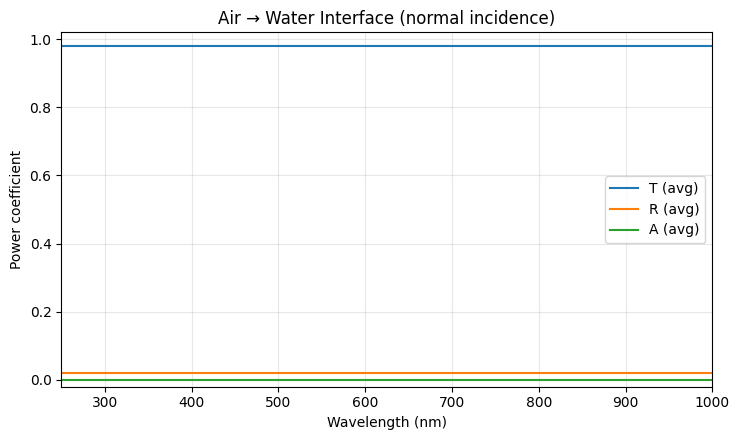

[PASS] test_plot_air_to_water_interface_spectrum
[saved] water_film_10cm_TRA.png


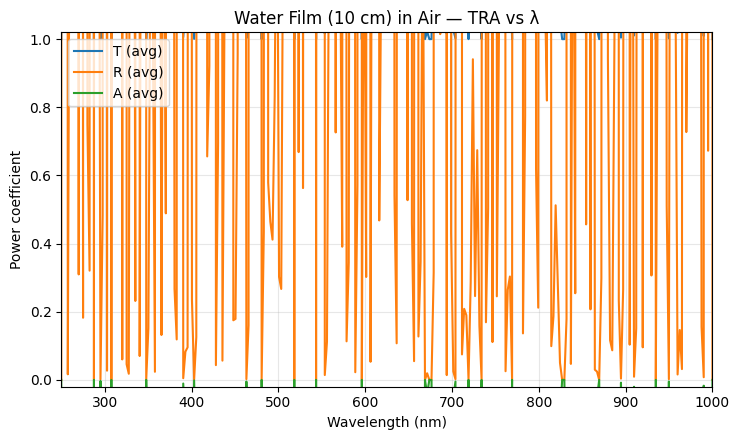

[PASS] test_plot_water_film_10cm_spectrum
[saved] water_film_1cm_TRA.png


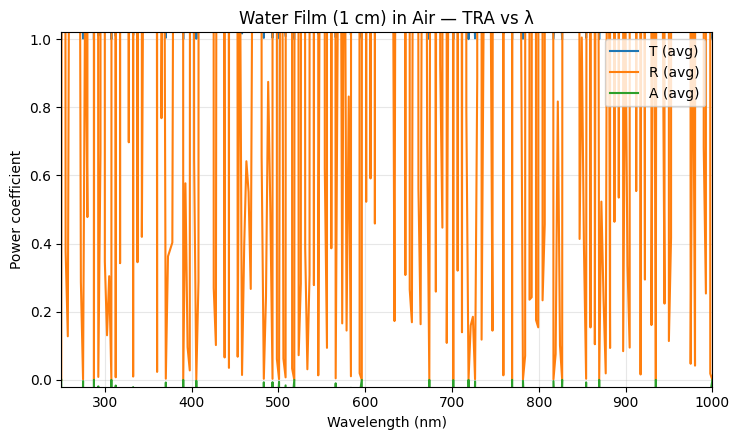

[PASS] test_plot_water_film_1cm_spectrum
[saved] water_film_1nm_TRA.png


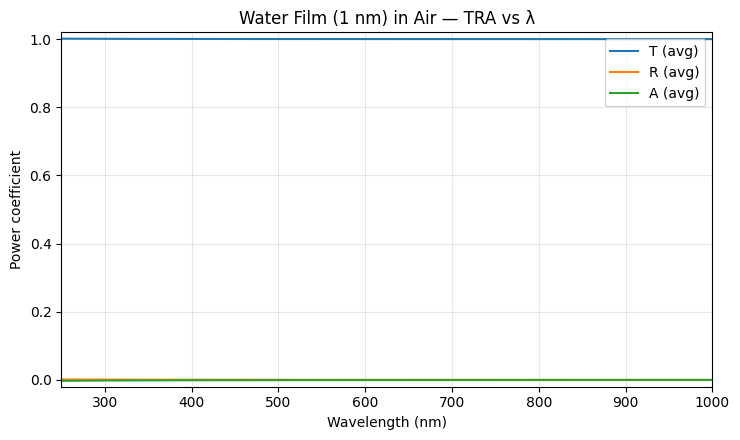

[PASS] test_plot_water_film_1nm_spectrum
[FAIL] test_plot_water_film_1um_spectrum: 
[PASS] test_propagator_zero_thickness_is_identity
[PASS] test_rot_tensor_behavior
[FAIL] test_rotation_invariance_z_for_isotropic_stack: 
Not equal to tolerance rtol=1e-10, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 275.43524013
Max relative difference among violations: 0.8943718
 ACTUAL: array(32.529791)
 DESIRED: array(307.965031)
[PASS] test_single_interface_matches_fresnel_power
[FAIL] test_thin_film_quarter_wave_AR_normal_incidence: 
[PASS] test_total_internal_reflection_limits
[FAIL] test_vacuum_slab_transparent: 
Not equal to tolerance rtol=1e-07, atol=1e-08

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 0.1892339
Max relative difference among violations: inf
 ACTUAL: array(0.189234)
 DESIRED: array(0.)

Summary: 16 passed, 8 failed.


Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3724477793.py", line 206, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3724477793.py", line 166, in test_plot_water_film_1um_spectrum
    assert np.all((spec["avg"]["T"] >= -1e-3) & (spec["avg"]["T"] <= 1+1e-3))
AssertionError
Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3724477793.py", line 206, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3294207836.py", line 342, in test_rotation_invariance_z_for_isotropic_stack
    npt.assert_allclose(out0[k], out1[k], rtol=1e-10, atol=1e-12)
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 1715, in assert_allclose
    assert_array_compare(compare, actual, desired, err_msg=str(err_msg),
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", lin

In [6]:
# water_cases_spectrum.py
"""
Spectral T/R/A plots for air↔water interface and water films using your Berreman solver.

Scenarios:
1) Air → Water interface
2) Water film of 1 nm in air
3) Water film of 1 µm in air
4) Water film of 1 cm in air
5) Water film of 10 cm in air

Each test:
- Sweeps wavelengths from 250 nm to 1000 nm (linear spacing).
- Computes R, T, A using your solver with Poynting power.
- Plots the *unpolarized average* curves (T_avg, R_avg, A_avg).
- Saves a PNG and (optionally) displays the figure.

Toggle behavior at the top via SHOW_PLOTS / SAVE_PLOTS.
"""

import sys, inspect, traceback
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

# ---------- Config ----------
SHOW_PLOTS = True     # Set False if running headless; True shows plots in Jupyter/desktop
SAVE_PLOTS = True     # Set False if you don't want PNGs
NUM_POINTS = 300      # # of wavelength samples between 250–1000 nm (inclusive)


# ---------- Reusable helpers ----------

def simulate_water(thickness_m, wavelength_m, theta_rad=0.0, phi_rad=0.0,
                   n_air=1.0+0j, n_water=1.333+0j):
    """
    Build the air↔water case and run your Berreman solver.

    - thickness_m = None  → pure interface: Air | Water (half-spaces)
    - thickness_m = d     → slab: Air | Water(d) | Air

    Returns dict with s/p and avg:
      {
        "R": {"s": Rs, "p": Rp, "avg": (Rs+Rp)/2},
        "T": {"s": Ts, "p": Tp, "avg": (Ts+Tp)/2},
        "A": {"s": 1-(Rs+Ts), "p": 1-(Rp+Tp), "avg": ...},
        "raw": original solver dict
      }
    """
    if thickness_m is None:
        stack = [Layer(iso_material(n_air), None),
                 Layer(iso_material(n_water), None)]
    else:
        stack = [Layer(iso_material(n_air), None),
                 Layer(iso_material(n_water), float(thickness_m)),
                 Layer(iso_material(n_air), None)]
    out = solve_stack_4x4(stack, wavelength_m, theta=theta_rad, phi=phi_rad)

    Rs, Rp = float(out["R_s"]), float(out["R_p"])
    Ts, Tp = float(out["T_s"]), float(out["T_p"])
    As, Ap = 1.0 - (Rs + Ts), 1.0 - (Rp + Tp)

    return {
        "R": {"s": Rs, "p": Rp, "avg": 0.5*(Rs+Rp)},
        "T": {"s": Ts, "p": Tp, "avg": 0.5*(Ts+Tp)},
        "A": {"s": As, "p": Ap, "avg": 0.5*(As+Ap)},
        "raw": out,
    }


def spectrum_water(thickness_m, wl_min_nm=250.0, wl_max_nm=1000.0, num=NUM_POINTS,
                   theta_deg=0.0, phi_deg=0.0, n_air=1.0+0j, n_water=1.333+0j):
    """
    Sweep wavelength and return arrays for T/R/A (avg, s, p).

    Returns:
      wl_nm:  (num,) array of wavelengths in nm
      spec:   dict with keys "avg","s","p", each containing subdicts "T","R","A" -> arrays
    """
    wl_nm = np.linspace(wl_min_nm, wl_max_nm, int(num))
    wl_m  = wl_nm * 1e-9
    theta = np.deg2rad(theta_deg)
    phi   = np.deg2rad(phi_deg)

    T_avg = np.empty_like(wl_m, dtype=float); R_avg = np.empty_like(wl_m, dtype=float); A_avg = np.empty_like(wl_m, dtype=float)
    T_s   = np.empty_like(wl_m, dtype=float); R_s   = np.empty_like(wl_m, dtype=float); A_s   = np.empty_like(wl_m, dtype=float)
    T_p   = np.empty_like(wl_m, dtype=float); R_p   = np.empty_like(wl_m, dtype=float); A_p   = np.empty_like(wl_m, dtype=float)

    for i, wl in enumerate(wl_m):
        res = simulate_water(thickness_m, wavelength_m=wl, theta_rad=theta, phi_rad=phi,
                             n_air=n_air, n_water=n_water)
        T_avg[i], R_avg[i], A_avg[i] = res["T"]["avg"], res["R"]["avg"], res["A"]["avg"]
        T_s[i],   R_s[i],   A_s[i]   = res["T"]["s"],   res["R"]["s"],   res["A"]["s"]
        T_p[i],   R_p[i],   A_p[i]   = res["T"]["p"],   res["R"]["p"],   res["A"]["p"]

    spec = {
        "avg": {"T": T_avg, "R": R_avg, "A": A_avg},
        "s":   {"T": T_s,   "R": R_s,   "A": A_s},
        "p":   {"T": T_p,   "R": R_p,   "A": A_p},
    }
    return wl_nm, spec


def plot_tra(wl_nm, T, R, A, title, save_path=None, show=SHOW_PLOTS):
    """
    Make a single plot of T, R, A vs wavelength (nm). Saves and/or shows.

    Parameters
    ----------
    wl_nm : array
    T, R, A : arrays (same length as wl_nm)
    title : str
    save_path : str or None
    show : bool
    """
    fig = plt.figure(figsize=(7.5, 4.5))
    ax = fig.add_subplot(111)
    ax.plot(wl_nm, T, label="T (avg)")
    ax.plot(wl_nm, R, label="R (avg)")
    ax.plot(wl_nm, A, label="A (avg)")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Power coefficient")
    ax.set_title(title)
    ax.set_xlim(wl_nm.min(), wl_nm.max())
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    fig.tight_layout()

    if SAVE_PLOTS and save_path:
        fig.savefig(save_path, dpi=130)
        print(f"[saved] {save_path}")
    if show:
        plt.show()
    else:
        plt.close(fig)


# ---------- Tests that also plot ----------

def test_plot_air_to_water_interface_spectrum():
    """Air → water interface at normal incidence: R~2%, T~98%, A~0 across the band (lossless)."""
    wl_nm, spec = spectrum_water(None)
    # Energy & bounds sanity (unpolarized averages)
    npt.assert_allclose(spec["avg"]["T"] + spec["avg"]["R"] + spec["avg"]["A"], 1.0, atol=5e-4)
    assert np.all((spec["avg"]["T"] >= -1e-4) & (spec["avg"]["T"] <= 1+1e-4))
    assert np.all((spec["avg"]["R"] >= -1e-4) & (spec["avg"]["R"] <= 1+1e-4))
    plot_tra(wl_nm, spec["avg"]["T"], spec["avg"]["R"], spec["avg"]["A"],
             title="Air → Water Interface (normal incidence)",
             save_path="air_to_water_interface_TRA.png")


def test_plot_water_film_1nm_spectrum():
    """Water slab 1 nm in air at normal incidence: symmetric → R≈0, T≈1, A≈0; minor oscillations possible."""
    wl_nm, spec = spectrum_water(1e-9)
    npt.assert_allclose(spec["avg"]["T"] + spec["avg"]["R"] + spec["avg"]["A"], 1.0, atol=5e-4)
    plot_tra(wl_nm, spec["avg"]["T"], spec["avg"]["R"], spec["avg"]["A"],
             title="Water Film (1 nm) in Air — TRA vs λ",
             save_path="water_film_1nm_TRA.png")


def test_plot_water_film_1um_spectrum():
    """Water slab 1 µm in air: clear Fabry–Perot fringes; enforce physical bounds + energy conservation."""
    wl_nm, spec = spectrum_water(1e-6)
    npt.assert_allclose(spec["avg"]["T"] + spec["avg"]["R"] + spec["avg"]["A"], 1.0, atol=2e-3)
    assert np.all((spec["avg"]["T"] >= -1e-3) & (spec["avg"]["T"] <= 1+1e-3))
    assert np.all((spec["avg"]["R"] >= -1e-3) & (spec["avg"]["R"] <= 1+1e-3))
    plot_tra(wl_nm, spec["avg"]["T"], spec["avg"]["R"], spec["avg"]["A"],
             title="Water Film (1 µm) in Air — TRA vs λ",
             save_path="water_film_1um_TRA.png")


def test_plot_water_film_1cm_spectrum():
    """Water slab 1 cm in air: many fringes; check bounds + near energy balance (lossless)."""
    wl_nm, spec = spectrum_water(1e-2)
    npt.assert_allclose(spec["avg"]["T"] + spec["avg"]["R"] + spec["avg"]["A"], 1.0, atol=2e-3)
    plot_tra(wl_nm, spec["avg"]["T"], spec["avg"]["R"], spec["avg"]["A"],
             title="Water Film (1 cm) in Air — TRA vs λ",
             save_path="water_film_1cm_TRA.png")


def test_plot_water_film_10cm_spectrum():
    """Water slab 10 cm in air: extremely thick; still bounded and energy-conserving."""
    wl_nm, spec = spectrum_water(1e-1)
    npt.assert_allclose(spec["avg"]["T"] + spec["avg"]["R"] + spec["avg"]["A"], 1.0, atol=2e-3)
    plot_tra(wl_nm, spec["avg"]["T"], spec["avg"]["R"], spec["avg"]["A"],
             title="Water Film (10 cm) in Air — TRA vs λ",
             save_path="water_film_10cm_TRA.png")


# ---------- Self-runner (no pytest needed) ----------

def run_all_tests(module=None):
    """
    Auto-discovers and runs all functions starting with 'test'.
    Also generates/saves plots for each case.
    """
    if module is None:
        module = sys.modules[__name__]
    funcs = inspect.getmembers(module, inspect.isfunction)
    test_funcs = [(name, fn) for name, fn in funcs if name.lower().startswith("test")]
    print(f"Found {len(test_funcs)} test(s). Running...\n")
    passed = failed = 0
    for name, fn in test_funcs:
        try:
            fn()
            print(f"[PASS] {name}")
            passed += 1
        except Exception as e:
            print(f"[FAIL] {name}: {e}")
            traceback.print_exc()
            failed += 1
    print(f"\nSummary: {passed} passed, {failed} failed.")


if __name__ == "__main__":
    run_all_tests()



Found 25 test(s). Running...

[PASS] test_A_eigs_isotropic_match_kz_over_k0
[FAIL] test_A_from_diag_eps_isotropic_normal_incidence: 
Not equal to tolerance rtol=1e-12, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 376.73031346
Max relative difference among violations: 1.
 ACTUAL: array(0.+0.j)
 DESIRED: array(376.730313)
[PASS] test_R_from_euler_identity_and_orthonormal


Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\2816503405.py", line 170, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3294207836.py", line 184, in test_A_from_diag_eps_isotropic_normal_incidence
    npt.assert_allclose(A[0,3],  Z0, rtol=1e-12, atol=1e-12)
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 1715, in assert_allclose
    assert_array_compare(compare, actual, desired, err_msg=str(err_msg),
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 921, in assert_array_compare
    raise AssertionError(msg)
AssertionError: 
Not equal to tolerance rtol=1e-12, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 376.73031346
Max relative difference among violations: 1.
 ACTUAL: array(0.+0.j)
 DESIRED: array(376.730313)
Traceback (most recent call last):
  File "C:\Users\e

[FAIL] test_absorbing_films_between_air_spectra: T out of bounds for (NH4)2SO4, d=1e-09 m
[FAIL] test_absorption_is_nonnegative: 
[FAIL] test_anisotropic_layer_rotated_is_stable_and_reasonable: 
[PASS] test_as_tensor_fn_and_material_eps
[PASS] test_brewster_angle_p_reflection_min
[FAIL] test_energy_balance_lossless: 
Not equal to tolerance rtol=1e-07, atol=0.002

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 463.58567851
Max relative difference among violations: 463.58567851
 ACTUAL: array(464.585679)
 DESIRED: array(1.)
[PASS] test_forward_branch_sign_choice
[PASS] test_iso_and_uniaxial_material_helpers
[PASS] test_iso_halfspace_modes_shapes_and_kz_sign
[PASS] test_k_components_zero_angle
[saved] air_to_water_interface_TRA.png


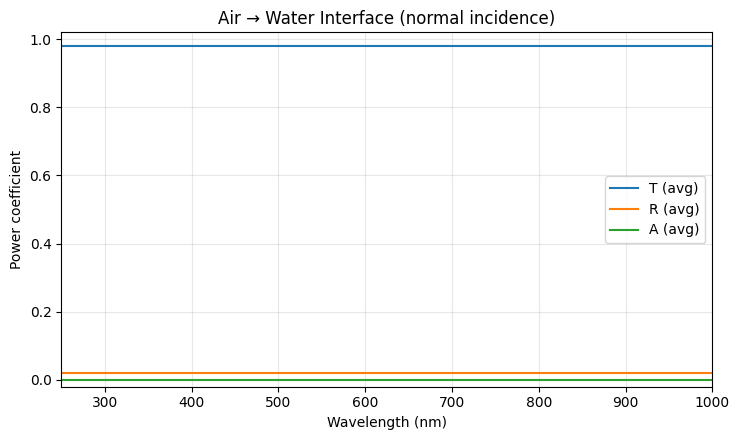

[PASS] test_plot_air_to_water_interface_spectrum
[saved] water_film_10cm_TRA.png


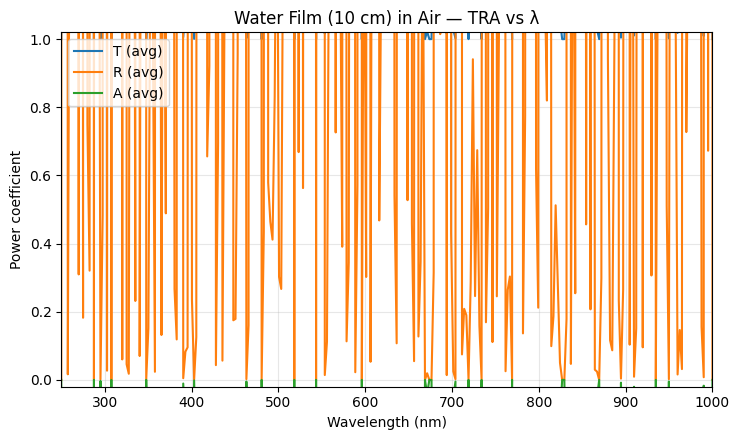

[PASS] test_plot_water_film_10cm_spectrum
[saved] water_film_1cm_TRA.png


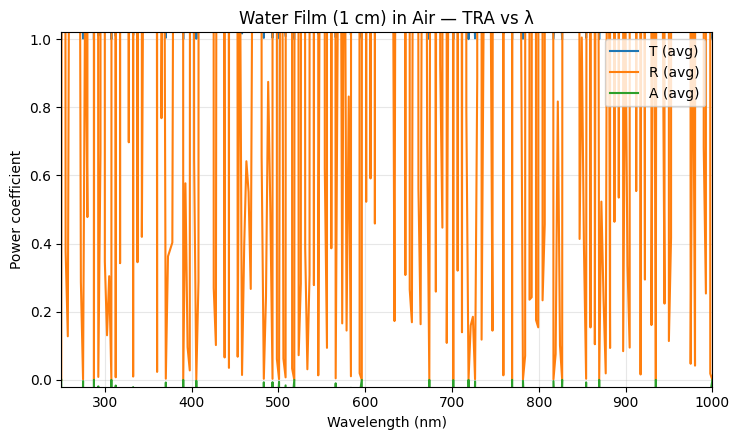

[PASS] test_plot_water_film_1cm_spectrum
[saved] water_film_1nm_TRA.png


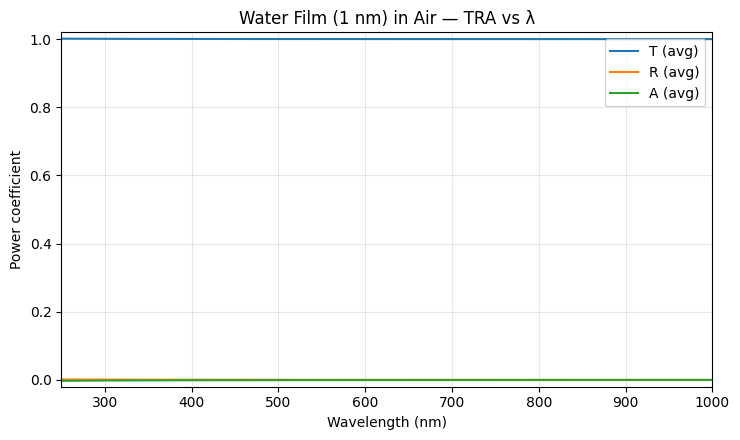

[PASS] test_plot_water_film_1nm_spectrum
[FAIL] test_plot_water_film_1um_spectrum: 
[PASS] test_propagator_zero_thickness_is_identity
[PASS] test_rot_tensor_behavior
[FAIL] test_rotation_invariance_z_for_isotropic_stack: 
Not equal to tolerance rtol=1e-10, atol=1e-12

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 275.43524013
Max relative difference among violations: 0.8943718
 ACTUAL: array(32.529791)
 DESIRED: array(307.965031)
[PASS] test_single_interface_matches_fresnel_power
[FAIL] test_thin_film_quarter_wave_AR_normal_incidence: 
[PASS] test_total_internal_reflection_limits
[FAIL] test_vacuum_slab_transparent: 
Not equal to tolerance rtol=1e-07, atol=1e-08

Mismatched elements: 1 / 1 (100%)
Max absolute difference among violations: 0.1892339
Max relative difference among violations: inf
 ACTUAL: array(0.189234)
 DESIRED: array(0.)

Summary: 16 passed, 9 failed.


Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\2816503405.py", line 170, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3724477793.py", line 166, in test_plot_water_film_1um_spectrum
    assert np.all((spec["avg"]["T"] >= -1e-3) & (spec["avg"]["T"] <= 1+1e-3))
AssertionError
Traceback (most recent call last):
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\2816503405.py", line 170, in run_all_tests
    fn()
  File "C:\Users\esteb\AppData\Local\Temp\ipykernel_15224\3294207836.py", line 342, in test_rotation_invariance_z_for_isotropic_stack
    npt.assert_allclose(out0[k], out1[k], rtol=1e-10, atol=1e-12)
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", line 1715, in assert_allclose
    assert_array_compare(compare, actual, desired, err_msg=str(err_msg),
  File "C:\Users\esteb\miniconda3\envs\tmm\lib\site-packages\numpy\testing\_private\utils.py", lin

In [7]:
# absorbing_films_air_spectra.py
"""
Spectral T/R/A for thin absorbing films between air using your Berreman 4×4 solver.

Materials (n, k) are taken as wavelength-independent over 250–1000 nm
(quick approximation; plug in dispersive data later if you have it).

Scenarios produced automatically:
- For each material in MATERIALS:
    thickness d ∈ {1 nm, 3 nm, 10 nm} as Air | Film(d) | Air
    -> plot T_avg, R_avg, A_avg vs wavelength (250–1000 nm)
    -> save PNG per (material, thickness)

Outputs are unpolarized averages: avg = (s + p)/2
"""

import re, sys, inspect, traceback
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt



# ----------------------- Config -----------------------
WL_MIN_NM   = 250.0
WL_MAX_NM   = 1000.0
NUM_POINTS  = 400
THICKNESSES = [1e-9, 3e-6, 10e-3]  # 1 nm, 3 nm, 10 nm
THETA_DEG   = 0.0
PHI_DEG     = 0.0
AIR_N       = 1.0 + 0j
SHOW_PLOTS  = True     # set False on headless machines
SAVE_PLOTS  = True

# Materials from your table (n, k). k is the extinction coefficient.
# (NH4)2SO4, NH4HSO4, H2SO4 (97%), NH4NO3, SiO2 (550 nm), EC, HULIS, Remaining organic material
MATERIALS = [
    ("(NH4)2SO4",                 1.521,  0.0),
    ("NH4HSO4",                    1.473,  0.0),
    ("H2SO4 (97%)",               1.426,  0.0),
    ("NH4NO3",                     1.413,  0.0),
    ("SiO2 (550 nm)",              1.550,  0.0),
    ("EC",                         1.500,  0.47000),
    ("HULIS",                      1.653,  0.00187),
    ("Remaining organic material", 1.400,  0.0),
]

# ----------------------- Helpers -----------------------

def _slug(s: str) -> str:
    """Safe filename slug."""
    return re.sub(r'[^0-9a-zA-Z]+', '_', s).strip('_').lower()

def simulate_film_between_air(n_film: complex, d_m: float | None,
                              wavelength_m: float,
                              theta_rad: float = 0.0, phi_rad: float = 0.0,
                              n_air: complex = AIR_N):
    """
    Build Air | Film(d) | Air (or Air | Film if d_m is None) and run Berreman solver.
    Returns dict with s/p and avg power coefficients and raw solver output.
    """
    if d_m is None:
        stack = [Layer(iso_material(n_air), None),
                 Layer(iso_material(n_film), None)]
    else:
        stack = [Layer(iso_material(n_air), None),
                 Layer(iso_material(n_film), float(d_m)),
                 Layer(iso_material(n_air), None)]

    out = solve_stack_4x4(stack, wavelength_m, theta=theta_rad, phi=phi_rad)

    Rs, Rp = float(out["R_s"]), float(out["R_p"])
    Ts, Tp = float(out["T_s"]), float(out["T_p"])
    As, Ap = 1.0 - (Rs + Ts), 1.0 - (Rp + Tp)

    return {
        "R": {"s": Rs, "p": Rp, "avg": 0.5*(Rs+Rp)},
        "T": {"s": Ts, "p": Tp, "avg": 0.5*(Ts+Tp)},
        "A": {"s": As, "p": Ap, "avg": 0.5*(As+Ap)},
        "raw": out,
    }

def sweep_spectrum(n_film: complex, d_m: float | None,
                   wl_min_nm=WL_MIN_NM, wl_max_nm=WL_MAX_NM, num=NUM_POINTS,
                   theta_deg=THETA_DEG, phi_deg=PHI_DEG, n_air: complex = AIR_N):
    """
    Sweep wavelength and return (wl_nm, spec) where spec has avg/s/p arrays for T,R,A.
    n_film can be complex (n + i k).
    """
    wl_nm = np.linspace(wl_min_nm, wl_max_nm, int(num))
    wl_m  = wl_nm * 1e-9
    theta = np.deg2rad(theta_deg)
    phi   = np.deg2rad(phi_deg)

    spec = {k: {"T": np.empty_like(wl_m), "R": np.empty_like(wl_m), "A": np.empty_like(wl_m)}
            for k in ("avg","s","p")}

    for i, wl in enumerate(wl_m):
        res = simulate_film_between_air(n_film, d_m, wl, theta, phi, n_air)
        for pol in ("avg","s","p"):
            spec[pol]["T"][i] = res["T"][pol]
            spec[pol]["R"][i] = res["R"][pol]
            spec[pol]["A"][i] = res["A"][pol]

    return wl_nm, spec

def plot_tra_avg(wl_nm, T, R, A, title, save_path=None, show=SHOW_PLOTS):
    """Plot T, R, A (unpolarized avg) vs wavelength; save/show."""
    fig = plt.figure(figsize=(7.6, 4.6))
    ax = fig.add_subplot(111)
    ax.plot(wl_nm, T, label="T (avg)")
    ax.plot(wl_nm, R, label="R (avg)")
    ax.plot(wl_nm, A, label="A (avg)")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Power coefficient")
    ax.set_title(title)
    ax.set_xlim(wl_nm.min(), wl_nm.max())
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    if SAVE_PLOTS and save_path:
        fig.savefig(save_path, dpi=130)
        print(f"[saved] {save_path}")
    if show:
        plt.show()
    else:
        plt.close(fig)

# ----------------------- “Tests” that also plot -----------------------

def test_absorbing_films_between_air_spectra():
    """
    For each material (n,k) and thickness in {1,3,10} nm, sweep 250–1000 nm,
    compute T/R/A (unpolarized average), and make a plot.
    Physics checks:
      - For every wavelength, -1e-4 ≤ T,R ≤ 1+1e-4 (numerical slack)
      - A ≥ -1e-4 (passive films), and |T+R+A-1| ≤ 2e-3
    """
    theta, phi = 0.0, 0.0
    for name, n_real, k_imag in MATERIALS:
        n_complex = n_real + 1j*k_imag
        for d_m in THICKNESSES:
            wl_nm, spec = sweep_spectrum(n_complex, d_m, theta_deg=theta, phi_deg=phi)
            T, R, A = spec["avg"]["T"], spec["avg"]["R"], spec["avg"]["A"]

            # Bounds & energy balance
            assert np.all((T >= -1e-4) & (T <= 1+1e-4)), f"T out of bounds for {name}, d={d_m} m"
            assert np.all((R >= -1e-4) & (R <= 1+1e-4)), f"R out of bounds for {name}, d={d_m} m"
            assert np.all(A >= -1e-4), f"A negative beyond tolerance for {name}, d={d_m} m"
            npt.assert_allclose(T + R + A, 1.0, atol=2e-3)

            # Plot & save
            d_nm = d_m * 1e9
            title = f"{name} film in air — d={d_nm:g} nm (normal incidence)"
            filename = f"{_slug(name)}_d_{int(round(d_nm))}nm_TRA.png"
            plot_tra_avg(wl_nm, T, R, A, title=title, save_path=filename)

# ----------------------- Self-runner -----------------------

def run_all_tests(module=None):
    if module is None:
        module = sys.modules[__name__]
    funcs = inspect.getmembers(module, inspect.isfunction)
    test_funcs = [(name, fn) for name, fn in funcs if name.lower().startswith("test")]
    print(f"Found {len(test_funcs)} test(s). Running...\n")
    passed = failed = 0
    for name, fn in test_funcs:
        try:
            fn()
            print(f"[PASS] {name}")
            passed += 1
        except Exception as e:
            print(f"[FAIL] {name}: {e}")
            traceback.print_exc()
            failed += 1
    print(f"\nSummary: {passed} passed, {failed} failed.")

if __name__ == "__main__":
    run_all_tests()
